In [27]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_X_y
from py_files.features import distance, generate_features
from config import data_path
import json
import seaborn as sbn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import time
import xgboost as xgb
import lightgbm as lgb
# import catboost as cb
pd.options.display.float_format = '{:.6f}'.format

In [6]:
X, y = get_X_y(force_clean=True)
X = generate_features(X, y)
X.head()

vendor_id     pickup_datetime  ...  cloudcover (%)  avg_cluster_duration
0          1 2016-03-14 17:24:55  ...           100.0            814.728261
1          1 2016-03-14 17:19:42  ...           100.0            802.820588
2          1 2016-03-14 16:57:39  ...           100.0            827.276087
3          1 2016-03-14 17:01:41  ...           100.0            893.413174
4          1 2016-03-14 17:16:07  ...           100.0            687.900000

[5 rows x 27 columns]

In [ ]:
# get all rows where precipitation (mm) = 0
sunny = X[X['precipitation (mm)'] == 0]['pickup_hour']
precip = X[X['precipitation (mm)'] > 0]['pickup_hour']

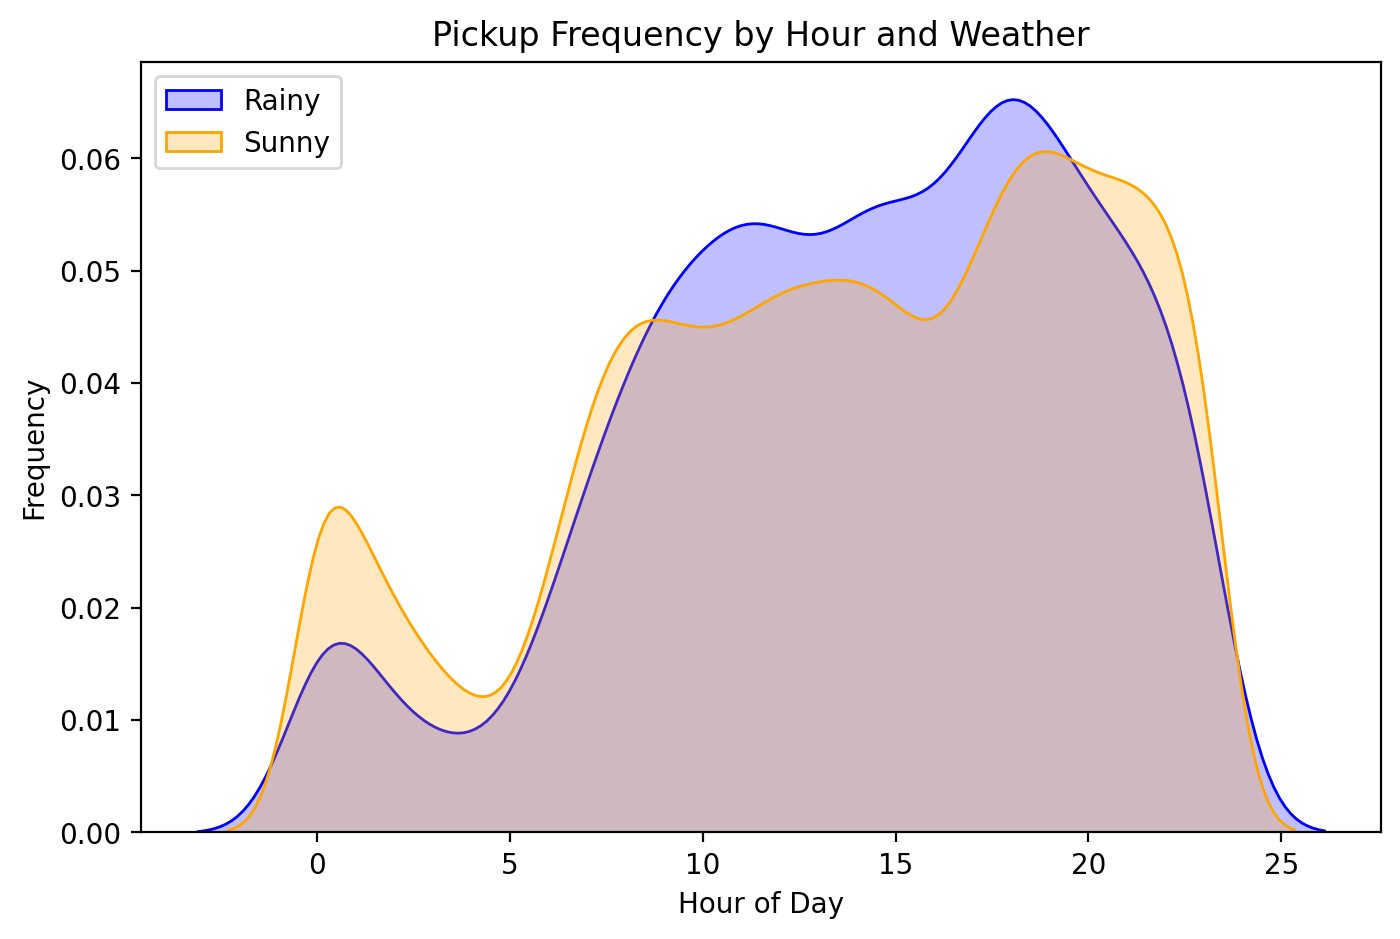

In [23]:
plt.figure(figsize=(8, 5), dpi=200)
sbn.kdeplot(precip, shade=True, label='Rainy', color='blue', bw_adjust=2)
sbn.kdeplot(sunny, shade=True, label='Sunny', color='orange', bw_adjust=2)
plt.title('Pickup Frequency by Hour and Weather')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

# Light GBM

In [28]:
X1 = X.drop(columns=['vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create param grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [30, 40],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
}

# LightGBM
lgb_train = lgb.LGBMRegressor()

# Grid search
grid_search = GridSearchCV(estimator=lgb_train, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 768861, number of used features: 25
[LightGBM] [Info] Start training from score 825.788793
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 768861, number of used features: 25
[LightGBM] [Info] Start training from score 825.844990
[LightGBM] [Warning] Fo

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05], 'max_depth': [10, 20],
                         'n_estimators': [100, 200], 'num_leaves': [30, 40],
                         'reg_alpha': [0.1, 0.5], 'reg_lambda': [0.1, 0.5]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [37]:
# Best params
review = {'Best parameters from grid search': grid_search.best_params_, 'Best MSE': -grid_search.best_score_}
print('Best parameters from grid search:')
# print a dictionary nicely
count = 0
for key, value in grid_search.best_params_.items():
    count += 1
    space = ":"
    if count > 2:
        space = ":\t"
    print("\t", key, space, value)
print('\nBest MSE:', -grid_search.best_score_)

print("\n", review)

Best parameters from grid search:
	 boosting_type : gbdt
	 learning_rate : 0.01
	 max_depth :	 20
	 n_estimators :	 100
	 num_leaves :	 30
	 reg_alpha :	 0.1
	 reg_lambda :	 0.5

Best MSE: 607.5797035091151

 {'Best parameters from grid search': {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.5}, 'Best MSE': 607.5797035091151}


In [39]:
# save the best version of lightgbm model so it can be loaded later
best_lgb = grid_search.best_estimator_
data_path = "./models/"
best_lgb.booster_.save_model(data_path + 'best_lgb.txt')

In [ ]:
# to load the model later
loadedlightgbm = lgb.Booster(model_file='./models/best_lgb.txt')